In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.optimize as spo

In [2]:
base_dir = '' # add your path to the directory where your .csv files are located

In [3]:
# settings for plots, you might want to adjust these
figsize=(10, 10)
symcol = {'SPY':'blue', 'GOLD':'gold', 'GOOG':'green', 'AAPL':'red'}
sns.set(context='talk')

In [4]:
"""Utility functions"""

def symbol_to_path(symbol, base_dir=base_dir):
    """Return CSV file path given ticker symbol."""
    return os.path.join(base_dir, "{}.csv".format(str(symbol)))

def get_data(symbols, dates, add_SPY=True):
    """Read stock data (adjusted close) for given symbols from CSV files."""
    df = pd.DataFrame(index=dates)
    
    if 'SPY' not in symbols:  # add SPY (S&P-500) as a reference if absent
        symbols.insert(0, 'SPY')

    for symbol in symbols:

        df_temp = pd.read_csv(symbol_to_path(symbol), index_col='Date', parse_dates=True, usecols=['Date', 'Adj Close'], na_values=['nan'])
        df_temp = df_temp.rename(columns={'Adj Close' : symbol})
        df = df.join(df_temp)
        
        if symbol == 'SPY':
            df = df.dropna(subset=["SPY"]) # drop dates SPY did not trade
    
    if not add_SPY: # drop again if SPY not part of portfolio
        df = df.drop(columns='SPY')    
        symbols.pop(0)

    return df
    
def plot_data(df, title='Stock Prices'):
    ax = df.plot(title=title)
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    plt.show()
    
def normalize_data(df):
    return df/df.iloc[0,:]

def compute_daily_returns(df):
    daily_returns = df.copy()
    daily_returns = df[1:].div(df[:-1].values, fill_value=0)-1 # use .values to access underlying numpy array, otherwise pandas will try and match indices which undoes the shifting. omit index 0 since always 0
    return daily_returns


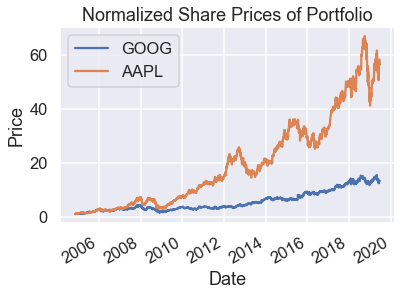

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.9500892942911973
            Iterations: 4
            Function evaluations: 17
            Gradient evaluations: 4
Optimal allocations for ['GOOG', 'AAPL']: [0.2055 0.7945] with sharpe ratio of 0.95


In [5]:
""""Portfolio optimizer (sharpe ratio)"""

def negative_sharpe(x, df_norm, risk_free):
    """    
    Function to minimize for an optimal portfolio based on maximal sharpe ratio.
    We're calculating the negative sharpe ratio to make sure to optimize for maximal (and not minimal) sharpe ratio.
  
  * x: list with allocations for sinlge stocks in a portfolio, these are our dependend variables.
         e.g. [0.8, 0.2] for GOOG, AAPL will allocate 80% Google and 20% Apple stocks to the portfolio.
         Make sure the sum of allocations is 1.
    * df_norm: dataframe with normalized stock prices for each stock in separate columns.
    """
    df_pf = (df_norm*x).sum(axis=1) # perform allocation and sum up to get total value of portfolio
    daily_return = compute_daily_returns(df_pf)
    
    # formula to calculate the sharpe ratio for a daily sampling frequency (252 trading days a year)
    neg_sharpe = (-1)*np.sqrt(252)*(daily_return-risk_free).mean()/daily_return.std() 
    return neg_sharpe
    
    
def run_portfolio_optimizer(dates, symbols, guess, risk_free_rate):
    """
    * dates: pandas date_range for selected stocks
    * symbols: list of strings for stock names
    * guess: list of initial guess for allocations
    * risk_free_rate: estimated daily risk free return to calculate sharpe ratio
    """
    # perform some checks
    assert len(guess) == len(symbols)
    assert np.sum(guess) == 1
    
    # get stock data, normalize and plot
    if 'SPY' in symbols:
        add_SPY = True
    else:
        add_SPY = False
    
    df = get_data(symbols, dates, add_SPY=add_SPY)
    df_norm = normalize_data(df)
    plot_data(df_norm, title='Normalized Share Prices of Portfolio')
    
    # define optimizer with boundary conditions and constraints
    bounds = [(0,1) for a in alloc_guess] # optimal values need to be within [0,1]
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x)-1}) # sum of allocations = 1      
    result = spo.minimize(negative_sharpe, guess, args=(df_norm, risk_free_rate), method='SLSQP', bounds=bounds, constraints=constraints, options={'disp':True})
    
    best_sharpe = (-1)*negative_sharpe(result.x, df_norm, risk_free_rate)
    print('Optimal allocations for {}: {} with sharpe ratio of {}'\
          .format(symbols, np.round(result.x,4), np.round(best_sharpe, 2)))
    
    
if __name__ == "__main__":
    # choose your portfolio
    dates = pd.date_range('2004-11-10', '2019-06-21')
    stocks = ['GOOG','AAPL'] # make sure you have downloaded the data (yahoo finance)
    alloc_guess = [0.3, 0.7] # initial guess for allocations
    
    # estimate risk free rate
    libor_yr = 0.023 #current annual libor rate is 2.3%
    risk_free_rate = np.power(1+libor_yr, 1/252)-1 # convert to daily rate
    
    run_portfolio_optimizer(dates, stocks, alloc_guess, risk_free_rate)
    
    
    


In [12]:
## test optimizer

